Plot the voltage signal $x(t)$ `trace1` from the microelectrode array and visually examine it. 
Spikes are very fast downward voltage excursions (sometimes reaching to ~ $ -100 \mu V$), followed 
by a small overshoot (zoom in to few spikes to see what they typically look like).

To get some sense of the signal, **plot a probability distribution function** (properly
normalized, so that $\int dx P (x) = 1$), of $x(t)$. **Estimate the error bars on the PDF**
by splitting the data multiple times into halves and compute the SD over PDF
estimates constructed from halves of the data. Is there any obvious feature for
negative voltages in the histogram where you could draw a threshold to recognize
the spikes easily? To identify the spikes, you can set a threshold. Scan a range of
thresholds, from $-70 \mu V$ and $-30 \mu V$ ; whenever the signal crosses the threshold
in a downward direction (please pay attention to this definition!), identify a
putative spike, and **plot the number of spikes as a function of the threshold**. By
examining the trace in detail, can you claim that any specific threshold is a good
choice for spike detection?

In [344]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import norm

In [345]:
# Import the data
trace1 = np.loadtxt(fname=('trace1.txt'))

### 1) Plot the voltage signal $x(t)$ `trace1` from the microelectrode array and visually examine it. Spikes are very fast downward voltage excursions (sometimes reaching to ~ $ -100 \mu V$), followed by a small overshoot (zoom in to few spikes to see what they typically look like).

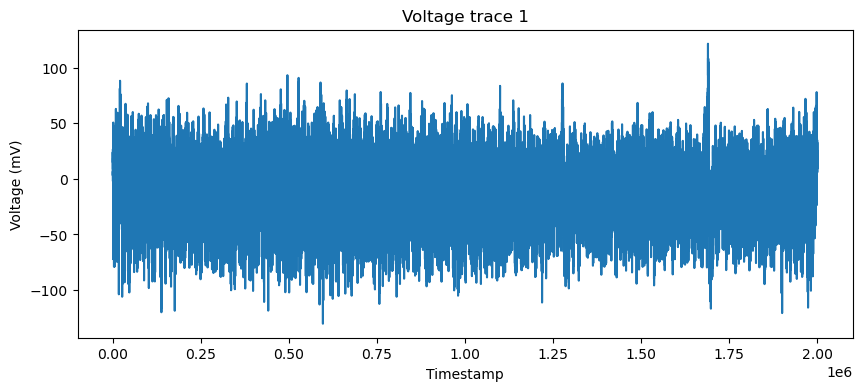

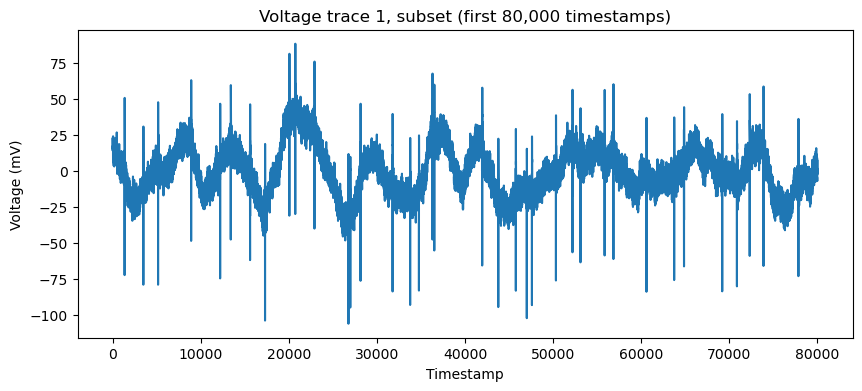

In [358]:
# Plot trace 1
plt.figure(figsize=(10,4))
plt.title('Voltage trace 1')
plt.xlabel('Timestamp')
plt.ylabel('Voltage (mV)')
plt.plot(trace1)
plt.show()

# Plot a subset
plt.figure(figsize=(10,4))
plt.title('Voltage trace 1, subset (first 80,000 timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Voltage (mV)')
plt.plot(trace1[0:80_000])
plt.show()

The data vector consists of $2 \times 10^6$ voltage samples, sampled at $2 \times 10^4 Hz$, for a total of 100 seconds. 100 seconds / $2 \times 10^6$ samples = $\frac{1}{20,000}$ = $5 \times 10^{-5}$ seconds per sample.

### 2) To get some sense of the signal, **plot a probability distribution function** (properly normalized, so that $\int dx P (x) = 1$), of $x(t)$.

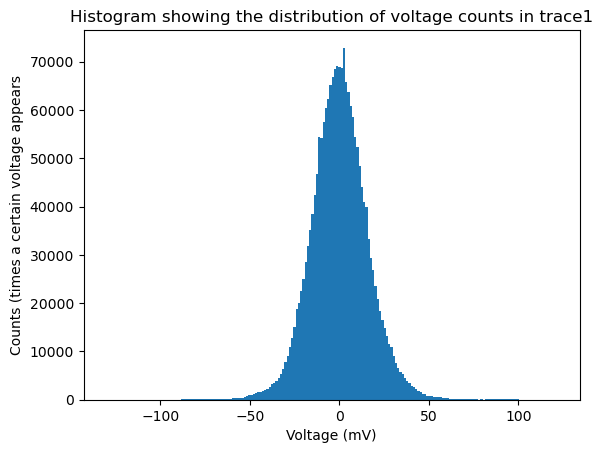

In [347]:
# First plot a histogram
numbins=200

plt.hist(trace1, bins=numbins)
plt.title('Histogram showing the distribution of voltage counts in trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('Counts (times a certain voltage appears')
plt.show()

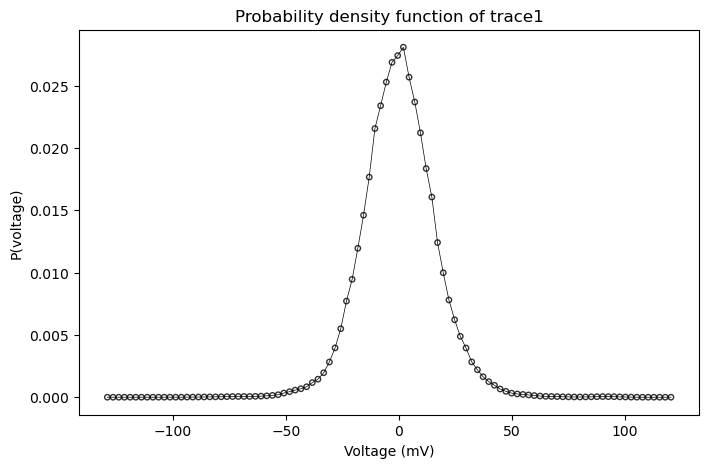

In [348]:
# Plot a normalized probability density function
numbins=100
counts, edges = np.histogram(trace1, bins=numbins, density=True)

# Get the center of the bin:
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin

# Plot the histogram:
plt.figure(figsize=(8,5))
plt.title('Probability density function of trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('P(voltage)')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')
plt.show()

# print(norm.support())

# # plt.plot(len(trace1), norm.pdf(trace1))
# plt.figure(figsize=(10,5))
# plt.plot(trace1, norm.pdf(trace1))
# plt.show()

The bin size was chosen to be 100 by trial and error. There are only 2022 unique values in the dataset (see below), so e.g. 1000 bins doesn't make sense.

In [349]:
len(np.unique(trace1))

2022

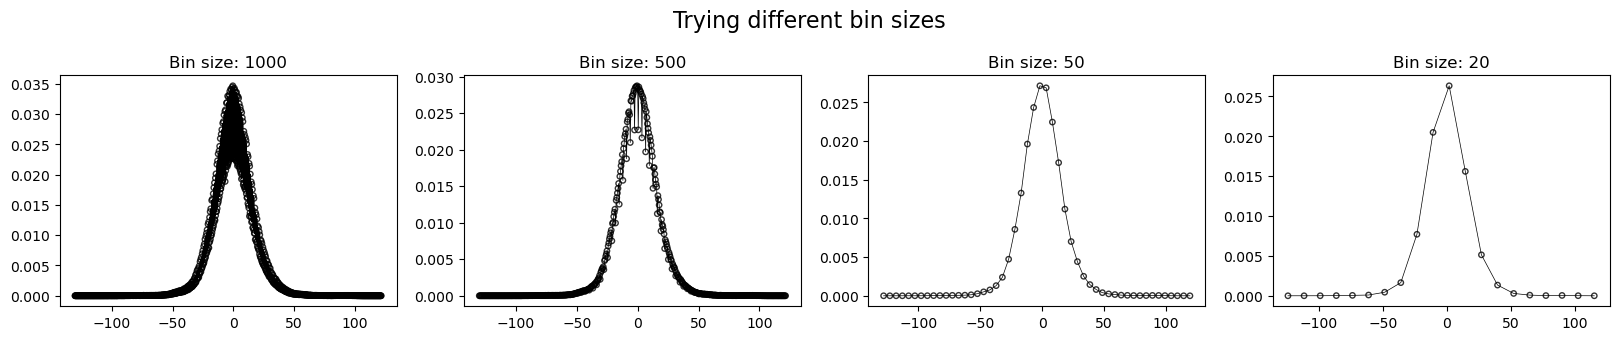

In [350]:
plt.figure(figsize=(20,3))
plt.suptitle('Trying different bin sizes', fontsize=16,y=1.1)

binsize=1000
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(141)
plt.title('Bin size: 1000')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=500
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(142)
plt.title('Bin size: 500')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=50
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(143)
plt.title('Bin size: 50')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=20
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(144)
plt.title('Bin size: 20')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

plt.show()

### 3) **Estimate the error bars** on the PDF by splitting the data multiple times into halves and compute the SD over PDF estimates constructed from halves of the data. Is there any obvious feature for negative voltages in the histogram where you could draw a threshold to recognize the spikes easily?

I plotted the PDF on a log scale to get a better sense of the nonlinearities, which should correspond to the spikes. Just judging by eye, these seems to begin at roughly $\pm 50 mV$. The error bars on the tails are also very large.

In [351]:
subsetSize = len(trace1)/2
repetitions = 100

def bootstrap(data, subsetSize, repetitions):
    '''
    Splits the data  into random halves (not preserving continuity, assuming IID) and calculates the standard deviation (std).
    Input: data, subsetSize = size of the random sample, repetitions = number of times to split the data and compute the std.
    Returns subsets (the randomly drawn points), pdfEstimates, which bins and estimates a PDF of the subset, pdfedges, the bin edges for pdfEstimates, and stdEstimates, the error bars.
    '''
    subsets = np.ndarray((repetitions, int(subsetSize)))
    pdfEstimates = np.ndarray((repetitions, numbins)) 
    stdEstimates = np.ndarray((repetitions, numbins))
    for run in range(repetitions):
        # randomly select half the data points (k = length of subset) and store in a matrix where the rows are subsets and the columns are runs
        subsets[run] = random.choices(data, k=int(subsetSize))
        # estimate the PDF from each subset, using the same number of bins as for our full PDF
        pdfEstimates[run], pdfedges = np.histogram(subsets[run], bins=numbins, density=True)
    # estimate the standard deviation of the PDF ????????????????
    stdEstimates = np.std(pdfEstimates, axis=0)
    return subsets, pdfEstimates, pdfedges, stdEstimates

subsets, pdfEstimates, pdfedges, stdEstimates = bootstrap(trace1, subsetSize, repetitions)

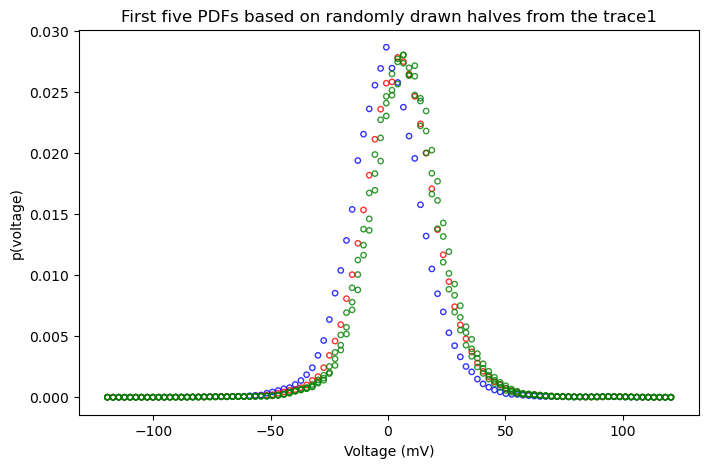

In [352]:
pdfbincenters = (pdfedges[1:]+pdfedges[:-1]) / 2
plt.figure(figsize=(8,5))
plt.title('First five PDFs based on randomly drawn halves from the trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('p(voltage)')
plt.scatter(pdfbincenters, pdfEstimates[0], marker='o', s=15,facecolors='none', edgecolors='b', alpha=0.8)
plt.scatter(pdfbincenters, pdfEstimates[1], marker='o', s=15,facecolors='none', edgecolors='r', alpha=0.8)
plt.scatter(pdfbincenters, pdfEstimates[2], marker='o', s=15,facecolors='none', edgecolors='g', alpha=0.8)
plt.scatter(pdfbincenters, pdfEstimates[3], marker='o', s=15,facecolors='none', edgecolors='g', alpha=0.8)
plt.scatter(pdfbincenters, pdfEstimates[4], marker='o', s=15,facecolors='none', edgecolors='g', alpha=0.8)
plt.show()

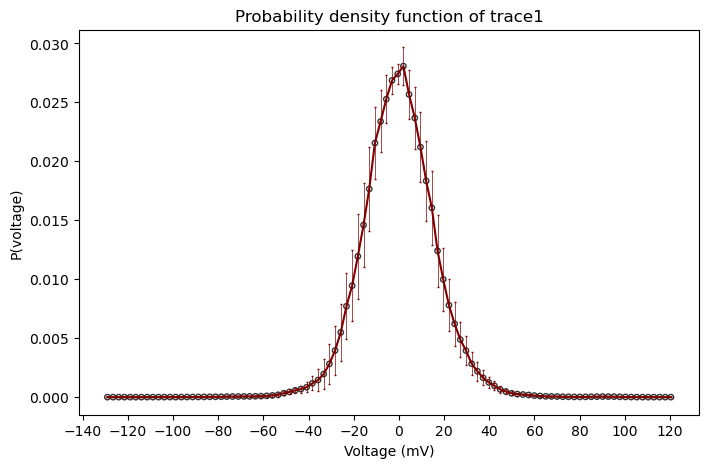

In [353]:
# Plot our normalized probability density function
numbins=100
counts, edges = np.histogram(trace1, bins=numbins, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
# print(edges)

# Plot the histogram:
plt.figure(figsize=(8,5))
plt.title('Probability density function of trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('P(voltage)')
plt.xticks(np.arange(-140, 140, 20))
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.errorbar(bin_centers, counts, yerr = stdEstimates, elinewidth=0.5, capsize=1, color='maroon')

plt.plot(bin_centers, counts, linewidth=.5, color='k')
plt.show()

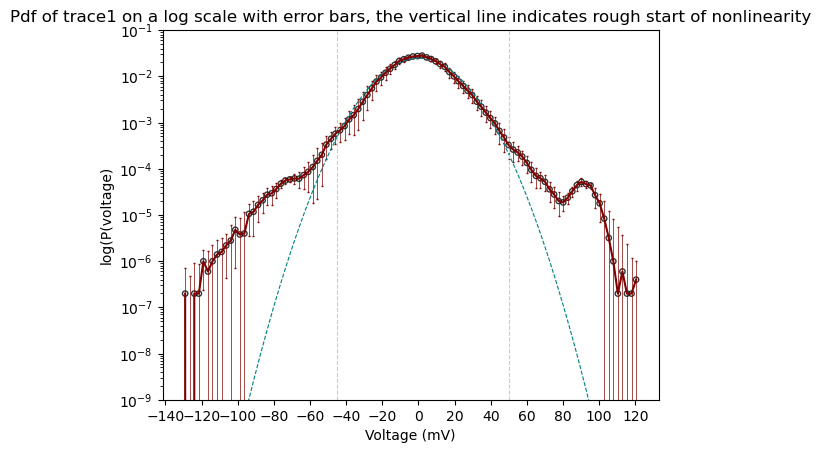

In [354]:
# Plot the histogram on a log scale
counts, edges = np.histogram(trace1, bins=numbins, density=True)

# Get the center of the bin:
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin

# Plot the histogram:
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.yscale('log')
plt.title('Pdf of trace1 on a log scale with error bars, the vertical line indicates rough start of nonlinearity')
plt.xlabel('Voltage (mV)')
plt.ylabel('log(P(voltage)')
plt.xticks(np.arange(-140, 140, 20))
plt.plot(bin_centers, counts, linewidth=.5, color='k')
plt.errorbar(bin_centers, counts, yerr = stdEstimates, elinewidth=0.5, capsize=1, color='maroon')

# Superimpose a normal distribution
mu = trace1.mean()
sigma = trace1.std()
normdist = stats.norm(mu, sigma)
x = np.linspace(bin_centers.min(), bin_centers.max(), numbins)
plt.plot(x, normdist.pdf(x), linestyle='--', linewidth=0.8, color='teal')
plt.axvline(x=-45, linestyle='--', linewidth=0.8, color='0.8')
plt.axvline(x=50, linestyle='--', linewidth=0.8, color='0.8')
plt.yscale('log')
plt.ylim(10e-10,10e-2)

plt.show()


### 4) To identify the spikes, you can set a threshold. Scan a range of thresholds, from $-70 \mu V$ and $-30 \mu V$ ; whenever the signal crosses the threshold in a downward direction (please pay attention to this definition!), identify a putative spike, and **plot the number of spikes as a function of the threshold**. By examining the trace in detail, can you claim that any specific threshold is a good choice for spike detection?
In order to gauge the threshold more accurately, it would be better to first remove the underlying oscillation signal. This can be done by binning the data and subtracting the mean.

In [379]:
thresholdRange = np.arange(-70, -30+1, 5)

def getSpikes(data, threshold_mV):
    '''
    This function returns the number of spikes given a threshold. A spike is defined as a point during which the 
    signal crosses the threshold in a downward direction.
    '''
    # For each timestamp check if the voltage dips below threshold_mV and is decreasing (next timestamp is more negative than previous one).
    # Note on finding whether the voltage is decreasing: np.diff returns e[i+1]-e[i], so np.diff(data)<0 returns True if the subsequent element is more negative.
    # Because we can't know whether the function is decreasing after the last element, our spike detection only works up to the last element of the data.
    boolSpike = (data[:-1]<threshold_mV) & (np.diff(data)<0)
    spikeCount = sum(boolSpike)
    spikeIdx = np.where(boolSpike)[0]
    
    return spikeCount, spikeIdx

spikeCounts = np.zeros(len(thresholdRange))
spikeIdx = np.zeros(len(thresholdRange))

for threshold in range(len(thresholdRange)):
    spikeCounts[threshold], _ = getSpikes(trace1, thresholdRange[threshold])


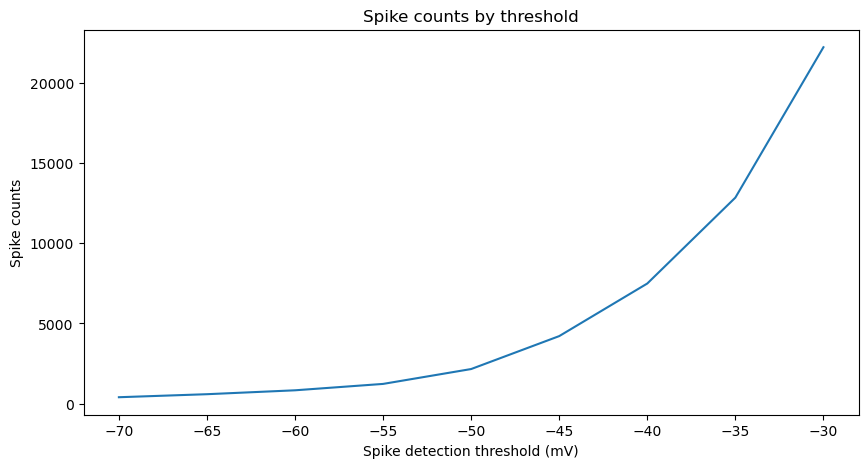

In [360]:
plt.figure(figsize=(10,5))
plt.title('Spike counts by threshold')
plt.xlabel('Spike detection threshold (mV)')
plt.ylabel('Spike counts')
plt.plot(thresholdRange,spikeCountsByThreshold)
plt.show()

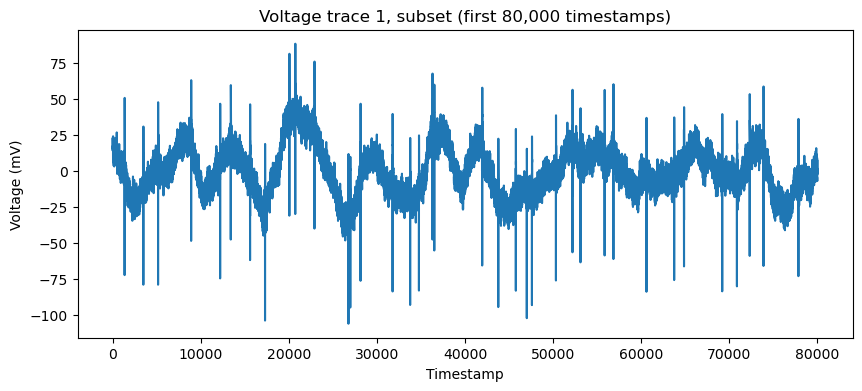

In [359]:
# Plot a subset
plt.figure(figsize=(10,4))
plt.title('Voltage trace 1, subset (first 80,000 timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Voltage (mV)')
plt.plot(trace1[0:80_000])
plt.show()